# Predicting AI Acceptance in Mental Health Interventions through Self-Determination Theory

This notebook prepares **analysis-ready datasets** and performs **core EDA** for a cross-cultural study of AI acceptance in mental health interventions.

**Goals of this notebook:**
1. Load and harmonize **China** and **USA** survey datasets.
2. Compute all composite scales:
   - Self-Determination (TENS_Life_mean)
   - Epistemic Trust (ET_mean)
   - Stigma (SSRPH_mean)
   - Depression (PHQ5_mean)
   - General AI Attitudes (GAAIS_mean)
   - AI Acceptance (UTAUT_AI_mean)
3. Construct **intervention-specific acceptance scores**:
   - Accept_avatar (AI avatar / generic AI therapist)
   - Accept_chatbot (AI chatbot)
   - Accept_tele (teletherapy / human therapist)
4. Create merged datasets:
   - `data/merged/merged.csv`
   - `data/merged/intersection.csv`
   - `data/merged/union_with_suffix.csv`
5. Check data quality:
   - Descriptives by country
   - Reliability (Cronbach’s alpha)
   - Missingness patterns
   - Multiple imputation for key hypothesis variables

## 0.0. Setup & Paths

In [298]:
from __future__ import annotations

import warnings
from pathlib import Path
from typing import List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# General plotting style
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# Paths
DATA_DIR = Path("data")
MERGED_DIR = DATA_DIR / "merged"
CHINA_DIR = DATA_DIR / "china"
USA_DIR = DATA_DIR / "usa"

MERGED_DIR.mkdir(parents=True, exist_ok=True)

# Key composite variables used later for EDA and summaries
KEY_COMPOSITES = ["TENS_Life_mean", "ET_mean", 
"SSRPH_mean", "PHQ5_mean", 
"GAAIS_mean", "UTAUT_AI_mean", 
"Accept_avatar", "Accept_chatbot", "Accept_tele"]

# 1.0. China Data Processing

China has three separate files that need to be coalesced:
- CN_all.csv - Combined sample
- CN_client.csv - Client-specific items
- CN_therapist.csv - Therapist-specific items

## 1.1. Load Raw China Files

In [299]:
cn_all = pd.read_csv(CHINA_DIR / "CN_all.csv")
cn_client = pd.read_csv(CHINA_DIR / "CN_client.csv")
cn_therapist = pd.read_csv(CHINA_DIR / "CN_therapist.csv")

print(f"CN_all: {cn_all.shape}")
print(f"CN_client: {cn_client.shape}")
print(f"CN_therapist: {cn_therapist.shape}")

CN_all: (485, 514)
CN_client: (216, 565)
CN_therapist: (269, 565)


In [239]:
cn_all.head()

,ID,responsetime,workinmh,workinmh_text,mh_service,receive_mh_service,age,gender,ethnicity,province,...,UTAUT_chatbot6,UTAUT_chatbot16,UTAUT_chatbot17,UTAUT_chatbot18,UTAUT_chatbot19,UTAUT_chatbot20,UTAUT_chatbot21,UTAUT_chatbot23,UTAUT_chatbot24,filter_$
0,380.0,3853.0,2.0,NaN,1.0,2.0,10.0,3.0,0.0,陕西省,...,2.0,2.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0,0.0
1,269.0,1778.0,2.0,NaN,1.0,1.0,17.0,3.0,0.0,上海市,...,1.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0
2,73.0,1810.0,2.0,NaN,1.0,2.0,2.0,3.0,0.0,黑龙江省,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0
3,544.0,2001.0,1.0,NaN,2.0,2.0,7.0,3.0,0.0,北京市,...,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0
4,415.0,1523.0,2.0,NaN,1.0,1.0,1.0,3.0,0.0,内蒙古自治区,...,3.0,3.0,2.0,3.0,2.0,3.0,2.0,2.0,3.0,1.0


## 1.2. Merge Client/Therapist Extras into CN_all

### 1.2.1. Identify extra columns in client/therapist files

In [300]:
# Find columns unique to client/therapist files
all_cols = set(cn_all.columns)
client_cols = set(cn_client.columns)
ther_cols = set(cn_therapist.columns)

# Columns that exist in client/therapist but not in all
missing_from_all = sorted(list((client_cols | ther_cols) - all_cols))

print(f"Found {len(missing_from_all)} columns to add from client/therapist files")
print(f"Examples: {missing_from_all[:5]}")

Found 53 columns to add from client/therapist files
Examples: ['AI_use_sum', 'AIavatar_CO_mean', 'AIavatar_EOU_mean', 'AIavatar_HC_mean', 'AIavatar_HM_mean']


In [301]:
# Get columns that overlap between client and therapist
overlap_cols = sorted(list(set(missing_from_all).intersection(client_cols).intersection(ther_cols)))
print(f"{len(overlap_cols)} columns exist in both client and therapist files")

53 columns exist in both client and therapist files


### 1.2.2. Prepare extra columns from each files

In [242]:
# Add suffixes to distinguish source
client_extra_cols = [c for c in missing_from_all if c in cn_client.columns]
therapist_extra_cols = [c for c in missing_from_all if c in cn_therapist.columns]

In [243]:
# Create separate dataframes with just ID and the extra columns
client_extra = cn_client[["ID"] + client_extra_cols].copy()
therapist_extra = cn_therapist[["ID"] + therapist_extra_cols].copy()

In [244]:
# Add suffixes to overlapping columns
client_extra = client_extra.rename(columns={c: f"{c}_client" for c in client_extra_cols})
therapist_extra = therapist_extra.rename(columns={c: f"{c}_therapist" for c in therapist_extra_cols})

In [302]:
# Merge into cn_all
cn_augmented = cn_all.merge(client_extra, on="ID", how="left")
cn_augmented = cn_augmented.merge(therapist_extra, on="ID", how="left")

In [303]:
print(f"Augmented CN_all from {cn_all.shape} to {cn_augmented.shape}")
cn_augmented.head()

Augmented CN_all from (485, 514) to (485, 620)


,ID,responsetime,workinmh,workinmh_text,mh_service,receive_mh_service,age,gender,ethnicity,province,...,chatbot_CO_mean_therapist,chatbot_EOU_mean_therapist,chatbot_HC_mean_therapist,chatbot_HM_mean_therapist,chatbot_PPR_mean_therapist,chatbot_SE_mean_therapist,chatbot_TQE_mean_therapist,chatbot_mean_therapist,stagesAI_mean_therapist,therapist_filter_therapist
0,380.0,3853.0,2.0,NaN,1.0,2.0,10.0,3.0,0.0,陕西省,...,3.0,3.5,2.75,4.0,2.5,3.5,3.666667,3.273810,4.428395,0.0
1,269.0,1778.0,2.0,NaN,1.0,1.0,17.0,3.0,0.0,上海市,...,5.0,5.0,2.00,5.0,1.0,5.0,5.000000,4.000000,5.000000,0.0
2,73.0,1810.0,2.0,NaN,1.0,2.0,2.0,3.0,0.0,黑龙江省,...,2.0,3.0,3.00,3.0,3.0,2.0,3.000000,2.714286,3.352469,0.0
3,544.0,2001.0,1.0,NaN,2.0,2.0,7.0,3.0,0.0,北京市,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,415.0,1523.0,2.0,NaN,1.0,1.0,1.0,3.0,0.0,内蒙古自治区,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.3. Coalesce Client/Therapist Columns & Create role_label

### 1.3.1. Create unified variables and create role label

In [304]:
# Create coalesced versions of overlapping columns
cn_coalesced = cn_augmented.copy()

# Get list of base names that have both _client and _therapist versions
client_suffix_cols = [c for c in cn_coalesced.columns if c.endswith("_client")]
therapist_suffix_cols = [c for c in cn_coalesced.columns if c.endswith("_therapist")]

# Find base names that exist in both
client_bases = {c.replace("_client", "") for c in client_suffix_cols}
therapist_bases = {c.replace("_therapist", "") for c in therapist_suffix_cols}
common_bases = sorted(list(client_bases & therapist_bases))

print(f"Found {len(common_bases)} variables with client/therapist versions")
print("Examples:", common_bases[:5])

Found 53 variables with client/therapist versions
Examples: ['AI_use_sum', 'AIavatar_CO_mean', 'AIavatar_EOU_mean', 'AIavatar_HC_mean', 'AIavatar_HM_mean']


### 1.3.3. Coalesce Data

In [305]:
# For each paired column, create a unified version
for base in common_bases:
    client_col = f"{base}_client"
    therapist_col = f"{base}_therapist"
    
    # Coalesce: use client value if available, otherwise therapist value
    cn_coalesced[base] = cn_coalesced[client_col].fillna(cn_coalesced[therapist_col])

In [306]:
# role_label based on the presence of client vs therapist data
sample_client_col = f"{common_bases[0]}_client"
sample_ther_col = f"{common_bases[0]}_therapist"

cn_coalesced["role_label"] = "unknown"
cn_coalesced.loc[cn_coalesced[sample_client_col].notna(), "role_label"] = "client"
cn_coalesced.loc[cn_coalesced[sample_ther_col].notna(), "role_label"] = "therapist"

print("Role distribution:")
print(cn_coalesced["role_label"].value_counts())

Role distribution:
role_label
therapist    269
client       216
Name: count, dtype: int64


## 1.4. Compute Composite Scores for China

### 1.4.1. Self-Determination (TENS_Life_mean)

In [307]:
# TENS_Life_mean (Self-Determination - 9 items, first 6 are reverse-coded)
tens_items = ['TENS_Life_1r', 'TENS_Life_2r', 'TENS_Life_3r', 'TENS_Life_4r', 'TENS_Life_5r', 
              'TENS_Life_6r', 'TENS_Life_7', 'TENS_Life_8', 'TENS_Life_9']

tens_available = [c for c in tens_items if c in cn_coalesced.columns]

cn_coalesced['TENS_Life_mean'] = cn_coalesced[tens_available].mean(axis=1)
print(f"TENS_Life_mean: {len(tens_available)}/9 items, Mean={cn_coalesced['TENS_Life_mean'].mean():.2f}")

TENS_Life_mean: 9/9 items, Mean=4.35


### 1.4.2. Epistemic Trust (ET_mean)

In [308]:
# ET_mean (Epistemic Trust - 15 items)
et_items = [f'ET_{i}' for i in range(1, 16)]

et_available = [c for c in et_items if c in cn_coalesced.columns]

cn_coalesced['ET_mean'] = cn_coalesced[et_available].mean(axis=1)

print(f"ET_mean: {len(et_available)}/15 items, Mean={cn_coalesced['ET_mean'].mean():.2f}")

ET_mean: 15/15 items, Mean=4.70


### 1.4.3. Stigma (SSRPH_mean)

In [309]:
# SSRPH_mean (Stigma - 5 items)
ssrph_items = [f'SSRPH_{i}' for i in range(1, 6)]

ssrph_available = [c for c in ssrph_items if c in cn_coalesced.columns]

cn_coalesced['SSRPH_mean'] = cn_coalesced[ssrph_available].mean(axis=1)

print(f"SSRPH_mean: {len(ssrph_available)}/5 items, Mean={cn_coalesced['SSRPH_mean'].mean():.2f}")

SSRPH_mean: 5/5 items, Mean=2.30


### 1.4.4. Depression (PHQ5_mean)

In [310]:
# PHQ5_mean (Depression - 5 items)
phq_items = [f'PHQ5_{i}' for i in range(1, 6)]

phq_available = [c for c in phq_items if c in cn_coalesced.columns]

cn_coalesced['PHQ5_mean'] = cn_coalesced[phq_available].mean(axis=1)

print(f"PHQ5_mean: {len(phq_available)}/5 items, Mean={cn_coalesced['PHQ5_mean'].mean():.2f}")

PHQ5_mean: 5/5 items, Mean=1.53


### 1.4.5. General AI Attitude (GAAIS_mean)

In [312]:
# GAAIS_mean (General AI Attitudes - using existing GAAIS_pos and GAAIS_neg if available)
cn_coalesced['GAAIS_mean'] = (cn_coalesced['GAAIS_pos'] + (8 - cn_coalesced['GAAIS_neg'])) / 2

# Overall is average of positive and (reversed) negative
print(f"GAAIS_mean: computed from pos/neg subscales, Mean={cn_coalesced['GAAIS_mean'].mean():.2f}")

GAAIS_mean: computed from pos/neg subscales, Mean=4.57


### 1.4.6. AI Acceptance (UTAUT_AI_mean)

In [313]:
# UTAUT_AI_mean (AI Acceptance - 26 items)
utaut_ai_items = [f'UTAUT_AI{i}' for i in range(1, 27)]
utaut_ai_items_with_r = []
for i in range(1, 27):
    if f'UTAUT_AI{i}r' in cn_coalesced.columns:
        utaut_ai_items_with_r.append(f'UTAUT_AI{i}r')
    elif f'UTAUT_AI{i}' in cn_coalesced.columns:
        utaut_ai_items_with_r.append(f'UTAUT_AI{i}')

if utaut_ai_items_with_r:
    cn_coalesced['UTAUT_AI_mean'] = cn_coalesced[utaut_ai_items_with_r].mean(axis=1)
    print(f"UTAUT_AI_mean: {len(utaut_ai_items_with_r)} items, Mean={cn_coalesced['UTAUT_AI_mean'].mean():.2f}")

UTAUT_AI_mean: 26 items, Mean=3.64


## 1.5. UTAUT Subscales & Intervention-Specific Acceptance (China)

### 1.5.1. UTAUT subscales helper and intervention-specific acceptance

In [314]:
def compute_utaut_subscales(df: pd.DataFrame, prefix: str = "UTAUT_AI") -> tuple[pd.DataFrame, Dict[str, int]]:
    """
    Compute UTAUT subscales for a given prefix (e.g., 'UTAUT_AI', 'UTAUT_chatbot', 'UTAUT_human').
    """
    subscale_mapping = {
        f"{prefix}_EOU_mean":  [1, 2, 3, 4],        # Ease of Use
        f"{prefix}_SI_mean":   [7, 8, 9],           # Social Influence
        f"{prefix}_CONV_mean": [10, 11, 12],        # Convenience
        f"{prefix}_HC_mean":   [13, 14, 22],        # Human Connection
        f"{prefix}_PPR_mean":  [16, 17, 18, 19, 20, 21],  # Privacy Risk (reversed)
        f"{prefix}_HM_mean":   [23, 24],            # Hedonic Motivation (reversed)
        f"{prefix}_TQE_mean":  [25, 26],            # Therapy Quality Expectancy
    }

    results: Dict[str, int] = {}

    for subscale_name, item_nums in subscale_mapping.items():
        cols = []
        for num in item_nums:
            if f"{prefix}{num}r" in df.columns:
                cols.append(f"{prefix}{num}r")
            elif f"{prefix}{num}" in df.columns:
                cols.append(f"{prefix}{num}")
        if cols:
            df[subscale_name] = df[cols].mean(axis=1)
            results[subscale_name] = len(cols)

    return df, results

In [315]:
# Compute subscales for each UTAUT version in China data
utaut_versions = ["UTAUT_AI", "UTAUT_chatbot", "UTAUT_human"]
all_results = {}

for version in utaut_versions:
    version_cols = [c for c in cn_coalesced.columns if c.startswith(version)]
    if version_cols:
        cn_coalesced, results = compute_utaut_subscales(cn_coalesced, prefix=version)
        all_results[version] = results
        print(f"{version}: computed {len(results)} subscales")
        for sub, k in results.items():
            print(f"  {sub:28} k={k}, M={cn_coalesced[sub].mean():.2f}")
        print()

UTAUT_AI: computed 7 subscales
  UTAUT_AI_EOU_mean            k=4, M=3.45
  UTAUT_AI_SI_mean             k=3, M=3.66
  UTAUT_AI_CONV_mean           k=3, M=3.85
  UTAUT_AI_HC_mean             k=3, M=3.87
  UTAUT_AI_PPR_mean            k=6, M=3.57
  UTAUT_AI_HM_mean             k=2, M=3.58
  UTAUT_AI_TQE_mean            k=2, M=3.74

UTAUT_chatbot: computed 7 subscales
  UTAUT_chatbot_EOU_mean       k=4, M=3.51
  UTAUT_chatbot_SI_mean        k=3, M=3.71
  UTAUT_chatbot_CONV_mean      k=3, M=3.83
  UTAUT_chatbot_HC_mean        k=3, M=3.90
  UTAUT_chatbot_PPR_mean       k=6, M=3.58
  UTAUT_chatbot_HM_mean        k=2, M=3.55
  UTAUT_chatbot_TQE_mean       k=2, M=3.77

UTAUT_human: computed 7 subscales
  UTAUT_human_EOU_mean         k=4, M=3.51
  UTAUT_human_SI_mean          k=3, M=3.71
  UTAUT_human_CONV_mean        k=3, M=3.83
  UTAUT_human_HC_mean          k=3, M=3.81
  UTAUT_human_PPR_mean         k=6, M=3.58
  UTAUT_human_HM_mean          k=2, M=3.59
  UTAUT_human_TQE_mean         k=2, M

In [316]:
# Recompute UTAUT_AI from subscales as a check
ai_subscales = [
    c for c in cn_coalesced.columns
    if c.startswith("UTAUT_AI_") and c.endswith("_mean")
    and any(f in c for f in ["EOU", "SI", "CONV", "HC", "PPR", "HM", "TQE"])
]
if ai_subscales:
    cn_coalesced["UTAUT_AI_mean_from_subscales"] = cn_coalesced[ai_subscales].mean(axis=1)
    corr = cn_coalesced[["UTAUT_AI_mean", "UTAUT_AI_mean_from_subscales"]].corr().iloc[0, 1]
    print(f"Recomputed UTAUT_AI_mean from {len(ai_subscales)} subscales.")
    print(f"Correlation with original: r = {corr:.3f}")

Recomputed UTAUT_AI_mean from 7 subscales.
Correlation with original: r = 0.984


### 1.5.2. Intervention-Specific Acceptance (China)

In [320]:
# Avatar / generic AI acceptance from UTAUT_AI subscales
if ai_subscales:
    cn_coalesced["Accept_avatar"] = cn_coalesced[ai_subscales].mean(axis=1)
    print(f"Accept_avatar (China): k={len(ai_subscales)}, "
          f"M={cn_coalesced['Accept_avatar'].mean():.2f}")

Accept_avatar (China): k=7, M=3.67


In [321]:
# Chatbot acceptance from UTAUT_chatbot subscales
cb_subscales = [
    c for c in cn_coalesced.columns
    if c.startswith("UTAUT_chatbot_") and c.endswith("_mean")
    and any(k in c for k in ["EOU", "SI", "CONV", "HC", "PPR", "HM", "TQE"])
]
if cb_subscales:
    cn_coalesced["Accept_chatbot"] = cn_coalesced[cb_subscales].mean(axis=1)
    print(f"Accept_chatbot (China): k={len(cb_subscales)}, "
          f"M={cn_coalesced['Accept_chatbot'].mean():.2f}")

Accept_chatbot (China): k=7, M=3.69


In [322]:
# Teletherapy / human therapist acceptance from UTAUT_human subscales
human_subscales = [
    c for c in cn_coalesced.columns
    if c.startswith("UTAUT_human_") and c.endswith("_mean")
    and any(k in c for k in ["EOU", "SI", "CONV", "HC", "PPR", "HM", "TQE"])
]
if human_subscales:
    cn_coalesced["Accept_tele"] = cn_coalesced[human_subscales].mean(axis=1)
    print(f"Accept_tele (China): k={len(human_subscales)}, "
          f"M={cn_coalesced['Accept_tele'].mean():.2f}")

Accept_tele (China): k=7, M=3.68


## 1.6.Add Country Label, Export China Data, China EDA


## 1.6.1. Add Country Label and Export China Data

In [323]:
# Add Country column
cn_coalesced['Country'] = 'China'

# Export to CSV
output_path = CHINA_DIR / "CN_all_coalesced.csv"
cn_coalesced.to_csv(output_path, index=False)

print("CHINA DATA COMPLETE")
print(f"Saved: {output_path}")
print(f"Shape: {cn_coalesced.shape}")
print(f"Participants: {len(cn_coalesced)}")
print(f"Variables: {len(cn_coalesced.columns)}")

CHINA DATA COMPLETE
Saved: data/china/CN_all_coalesced.csv
Shape: (485, 704)
Participants: 485
Variables: 704


### 1.6.2. Distribution Checks for Key Composite Variables

In [324]:
available_composites_cn = [c for c in KEY_COMPOSITES if c in cn_coalesced.columns]

print("Key composite scores (China):")
for comp in available_composites_cn:
    n_valid = cn_coalesced[comp].notna().sum()
    mean = cn_coalesced[comp].mean()
    print(f"{comp:20} {n_valid:3} valid, M={mean:.2f}")

Key composite scores (China):
TENS_Life_mean       485 valid, M=4.35
ET_mean              485 valid, M=4.70
SSRPH_mean           485 valid, M=2.30
PHQ5_mean            485 valid, M=1.53
GAAIS_mean           485 valid, M=4.57
UTAUT_AI_mean        485 valid, M=3.64
Accept_avatar        485 valid, M=3.67
Accept_chatbot       485 valid, M=3.69
Accept_tele          485 valid, M=3.68


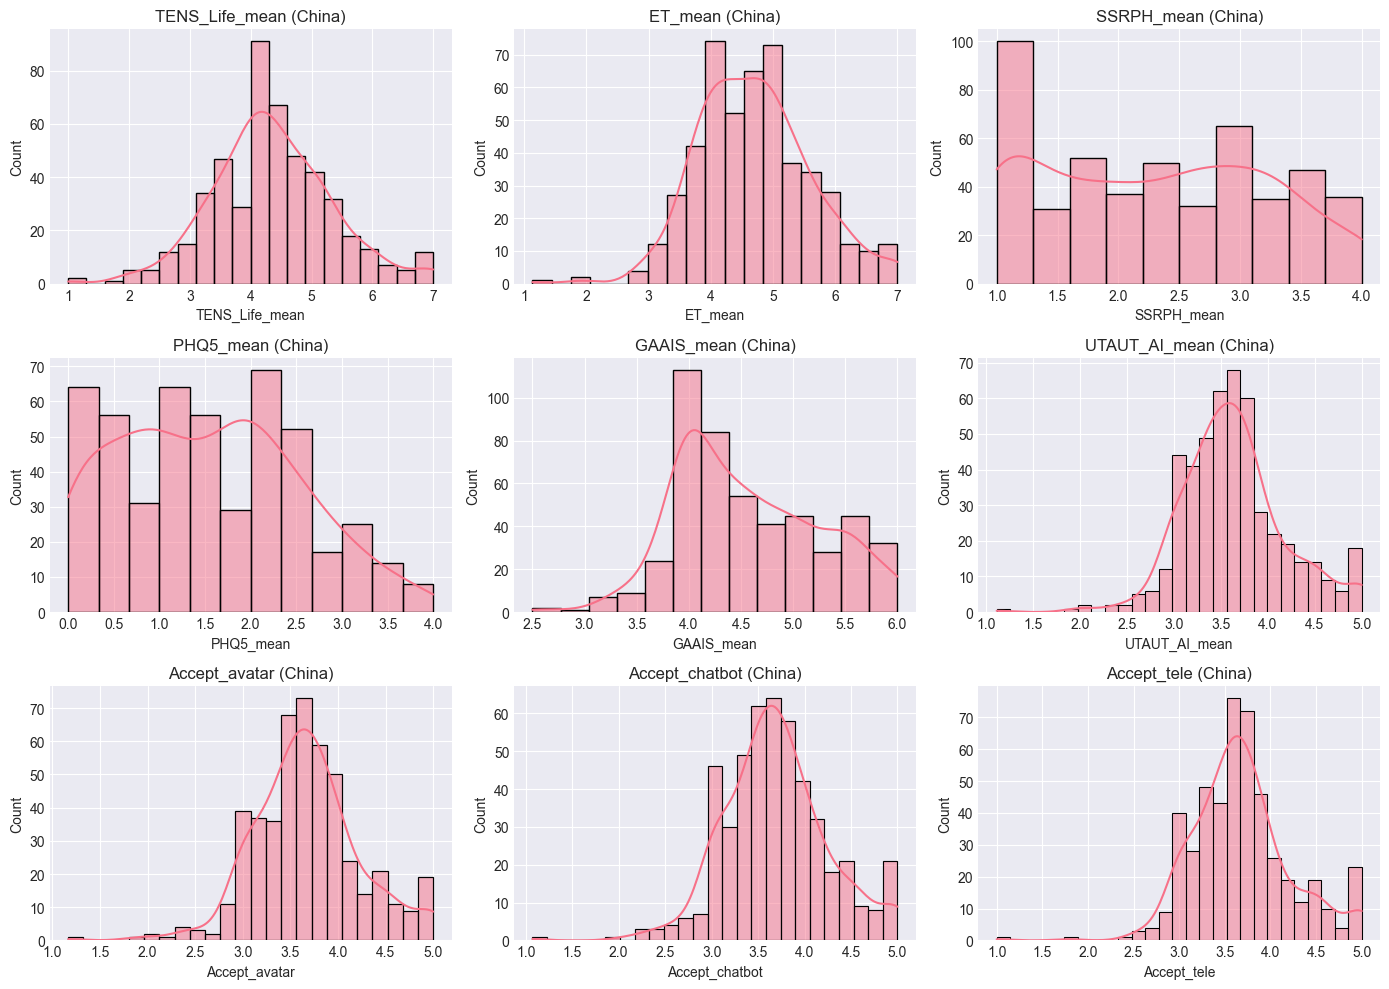

In [325]:
# Distributions of main composites
fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.ravel()

for ax, comp in zip(axes, available_composites_cn):
    sns.histplot(cn_coalesced[comp], kde=True, ax=ax)
    ax.set_title(f"{comp} (China)")

for ax in axes[len(available_composites_cn):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# 2.0. USA Data Pipeline

## 2.1. Load USA Data & Standardize Names

In [264]:
# Load USA data
usa_all = pd.read_csv(USA_DIR / "USA_all.csv", low_memory=False)
print(f"USA_all: {usa_all.shape}")

USA_all: (1857, 624)


### 2.1.1 Standardize USA Column Names
- Aligns variable names China vs USA, crucial for later merging.
- Keeps this logic in one cell.

In [265]:
# Create mapping dictionary for USA column renaming
usa_renamed = usa_all.copy()

# Rename demographics to match China
rename_map = {}
if 'Age' in usa_renamed.columns and 'age' not in usa_renamed.columns:
    rename_map['Age'] = 'age'
if 'Gender' in usa_renamed.columns and 'gender' not in usa_renamed.columns:
    rename_map['Gender'] = 'gender'
if 'Edu' in usa_renamed.columns and 'edu' not in usa_renamed.columns:
    rename_map['Edu'] = 'edu'

# Rename PHQ_5 to PHQ5
for i in range(1, 6):
    if f"PHQ_5_{i}" in usa_renamed.columns:
        rename_map[f"PHQ_5_{i}"] = f"PHQ5_{i}"
if "PHQ_5_mean" in usa_renamed.columns:
    rename_map["PHQ_5_mean"] = "PHQ5_mean"

# Apply renaming
usa_renamed.rename(columns=rename_map, inplace=True)
print(f"Renamed {len(rename_map)} columns (USA). Examples:", list(rename_map.items())[:5])

Renamed 9 columns (USA). Examples: [('Age', 'age'), ('Gender', 'gender'), ('Edu', 'edu'), ('PHQ_5_1', 'PHQ5_1'), ('PHQ_5_2', 'PHQ5_2')]


## 2.2 Compute Composite Scores for USA

### 2.2.1. Self-Determination (TENS_Life_mean)

In [328]:
# TENS_Life_mean (needs reverse-coding 1–6; 7–9 as is)
tens_items_usa = [f"TENS_Life_{i}" for i in range(1, 10)]
tens_available_usa = [c for c in tens_items_usa if c in usa_renamed.columns]

usa_reversed = usa_renamed.copy()
for i in range(1, 7):
    col = f"TENS_Life_{i}"
    if col in usa_reversed.columns:
        usa_reversed[f"TENS_Life_{i}r"] = 8 - usa_reversed[col]

for i in range(1, 7):
    rcol = f"TENS_Life_{i}r"
    if rcol in usa_reversed.columns:
        usa_renamed[rcol] = usa_reversed[rcol]

tens_for_mean = [f"TENS_Life_{i}r" for i in range(1, 7)] + [f"TENS_Life_{i}" for i in range(7, 10)]
tens_for_mean = [c for c in tens_for_mean if c in usa_reversed.columns]
usa_renamed["TENS_Life_mean"] = usa_reversed[tens_for_mean].mean(axis=1)
print(f"TENS_Life_mean: {len(tens_available_usa)} items, "
      f"Mean={usa_renamed['TENS_Life_mean'].mean():.2f}")

TENS_Life_mean: 9 items, Mean=4.88


### 2.2.2. Epistemic Trust (ET_mean)

In [327]:
# ET_mean
et_items = [f'ET_{i}' for i in range(1, 16)]

et_available = [c for c in et_items if c in usa_renamed.columns]

usa_renamed['ET_mean'] = usa_renamed[et_available].mean(axis=1)

print(f"ET_mean: {len(et_available)}/15 items, Mean={usa_renamed['ET_mean'].mean():.2f}")

ET_mean: 15/15 items, Mean=4.15


### 2.2.3. Stigma (SSRPH_mean)

In [329]:
# SSRPH_mean
ssrph_items = [f'SSRPH_{i}' for i in range(1, 6)]

ssrph_available = [c for c in ssrph_items if c in usa_renamed.columns]

usa_renamed['SSRPH_mean'] = usa_renamed[ssrph_available].mean(axis=1)

print(f"SSRPH_mean: {len(ssrph_available)}/5 items, Mean={usa_renamed['SSRPH_mean'].mean():.2f}")

SSRPH_mean: 5/5 items, Mean=0.93


### 2.2.4. Depression (PHQ5_mean)

In [330]:
# PHQ-5 mean
phq_items = [f'PHQ5_{i}' for i in range(1, 6)]

phq_available = [c for c in phq_items if c in usa_renamed.columns]

usa_renamed['PHQ5_mean'] = usa_renamed[phq_available].mean(axis=1)

print(f"PHQ5_mean: {len(phq_available)}/5 items, Mean={usa_renamed['PHQ5_mean'].mean():.2f}")

PHQ5_mean: 5/5 items, Mean=1.39


### 2.2.5. General AI Attitude

In [331]:
# GAAIS_mean
usa_renamed['GAAIS_mean'] = (usa_renamed['GAAIS_pos'] + (8 - usa_renamed['GAAIS_neg'])) / 2
print(f"GAAIS_mean: computed from pos/neg subscales, Mean={usa_renamed['GAAIS_mean'].mean():.2f}")

GAAIS_mean: computed from pos/neg subscales, Mean=4.62


### 2.2.6. AI Acceptance (UTAUT_AI_mean) from 86 items

In [332]:
# UTAUT - USA has different structure (UTAUT_1_X, UTAUT_2_X, UTAUT_3_X)
# We'll average across all UTAUT items for simplicity
utaut_cols = [c for c in usa_renamed.columns if c.startswith('UTAUT_') and '_' in c[6:]]
utaut_cols = [c for c in utaut_cols if 'validation' not in c.lower()]

usa_renamed['UTAUT_AI_mean'] = usa_renamed[utaut_cols].mean(axis=1)
print(f"UTAUT_AI_mean: {len(utaut_cols)} items, Mean={usa_renamed['UTAUT_AI_mean'].mean():.2f}")

UTAUT_AI_mean: 87 items, Mean=5.10


### Important Note on UTAUT Measurement

> [!WARNING]
> **Measurement Differences Across Countries:**
> - **China:** Uses a 26-item UTAUT_AI scale designed for AI acceptance in mental health
> - **USA:** Uses an 86-item composite UTAUT measure (includes multiple versions: AIavatar, etc.)
> - Both are treated as "AI Acceptance" (`UTAUT_AI_mean`) but represent **different instruments**
> - This measurement difference should be considered when interpreting cross-cultural comparisons
> - Subscale analyses may vary in validity across countries due to different item pools

## 2.3. Intervention-Specific Acceptance (USA)

### 2.3.1. Mapping
- UTAUT_1_* -> avatar AI
- UTAUT_2_* -> chatbot AI
- UTAUT_3_* -> teletherapy / human therapist

In [333]:
avatar_cols_usa = [c for c in usa_renamed.columns if c.startswith("UTAUT_1_")]
chatbot_cols_usa = [c for c in usa_renamed.columns if c.startswith("UTAUT_2_")]
human_cols_usa = [c for c in usa_renamed.columns if c.startswith("UTAUT_3_")]

if avatar_cols_usa:
    usa_renamed["Accept_avatar"] = usa_renamed[avatar_cols_usa].mean(axis=1)
    print(f"Accept_avatar (USA): k={len(avatar_cols_usa)}, M={usa_renamed['Accept_avatar'].mean():.2f}")

if chatbot_cols_usa:
    usa_renamed["Accept_chatbot"] = usa_renamed[chatbot_cols_usa].mean(axis=1)
    print(f"Accept_chatbot (USA): k={len(chatbot_cols_usa)}, M={usa_renamed['Accept_chatbot'].mean():.2f}")

if human_cols_usa:
    usa_renamed["Accept_tele"] = usa_renamed[human_cols_usa].mean(axis=1)
    print(f"Accept_tele (USA): k={len(human_cols_usa)}, M={usa_renamed['Accept_tele'].mean():.2f}")

Accept_avatar (USA): k=11, M=3.72
Accept_chatbot (USA): k=11, M=3.71
Accept_tele (USA): k=11, M=2.42


## 2.4. Country Label, role_label Placeholder, USA EDA

### 2.4.1. Add Country Label for USA

In [274]:
# Add Country column
usa_renamed['Country'] = 'USA'

print("USA DATA COMPLETE")
print(f"Shape: {usa_renamed.shape}")
print(f"Participants: {len(usa_renamed)}")
print(f"Variables: {len(usa_renamed.columns)}")

USA DATA COMPLETE
Shape: (1857, 639)
Participants: 1857
Variables: 639


### 2.4.2. If a 'role' variable exists, map to client/therapist

In [334]:
usa_renamed["role_label"] = "unknown"

# replace these conditions with your actual codebook
if "role" in usa_renamed.columns:
    usa_renamed.loc[usa_renamed["role"] == 1, "role_label"] = "client"
    usa_renamed.loc[usa_renamed["role"] == 2, "role_label"] = "therapist"

print("USA role_label distribution:")
print(usa_renamed["role_label"].value_counts())

USA role_label distribution:
role_label
unknown    1857
Name: count, dtype: int64


### 2.4.3. USA Key Composites Summaries

In [335]:
available_composites_usa = [c for c in KEY_COMPOSITES if c in usa_renamed.columns]
print("Key composite scores (USA):")
for comp in available_composites_usa:
    n_valid = usa_renamed[comp].notna().sum()
    mean = usa_renamed[comp].mean()
    print(f"{comp:20} {n_valid:4} valid, M={mean:.2f}")

Key composite scores (USA):
TENS_Life_mean       1618 valid, M=4.88
ET_mean              1620 valid, M=4.15
SSRPH_mean           1607 valid, M=0.93
PHQ5_mean            1621 valid, M=1.39
GAAIS_mean           1726 valid, M=4.62
UTAUT_AI_mean        1677 valid, M=5.10
Accept_avatar        1677 valid, M=3.72
Accept_chatbot       1665 valid, M=3.71
Accept_tele          1677 valid, M=2.42


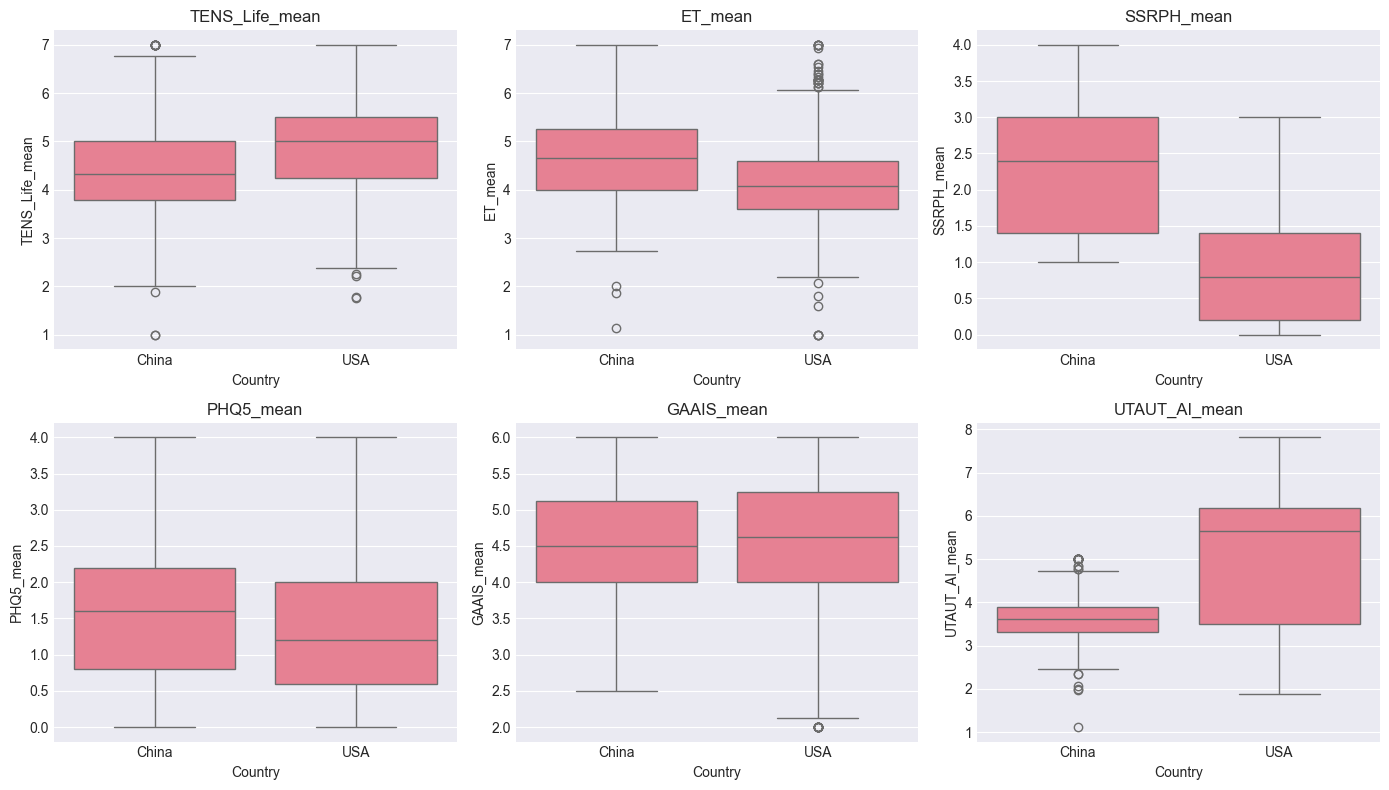

In [336]:
# Visual comparison
tmp = pd.concat([
    cn_coalesced[["Country"] + key_composites],
    usa_renamed[["Country"] + key_composites]
], ignore_index=True)

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.ravel()

for ax, comp in zip(axes, key_composites):
    sns.boxplot(data=tmp, x="Country", y=comp, ax=ax)
    ax.set_title(comp)

plt.tight_layout()
plt.show()

# 3.0. Cross-Country Merge & Dataset Variants

Create a single merged dataset with columns that exist in both countries.

## 3.1. Identify Common & Country-Specific Columns, Build Merged/Intersection/Union

In [337]:
# Find common columns
cn_cols = set(cn_coalesced.columns)
usa_cols = set(usa_renamed.columns)

common_cols = sorted(list(cn_cols & usa_cols))
cn_only = sorted(list(cn_cols - usa_cols))
usa_only = sorted(list(usa_cols - cn_cols))

print(f"Common columns: {len(common_cols)}")
print(f"China-only columns: {len(cn_only)}")
print(f"USA-only columns: {len(usa_only)}")

Common columns: 273
China-only columns: 431
USA-only columns: 368


In [338]:
# Ensure key variables are in common columns
key_vars = [
    "Country", "age", "gender", "edu",
    "TENS_Life_mean", "ET_mean", "SSRPH_mean",
    "PHQ5_mean", "GAAIS_mean", "UTAUT_AI_mean",
    "GAAIS_pos", "GAAIS_neg",
    "Accept_avatar", "Accept_chatbot", "Accept_tele",
]

key_vars_available = [v for v in key_vars if v in common_cols]

print(f"Key variables in common: {len(key_vars_available)}/{len(key_vars)}")
print(f"Available: {key_vars_available}")

Key variables in common: 15/15
Available: ['Country', 'age', 'gender', 'edu', 'TENS_Life_mean', 'ET_mean', 'SSRPH_mean', 'PHQ5_mean', 'GAAIS_mean', 'UTAUT_AI_mean', 'GAAIS_pos', 'GAAIS_neg', 'Accept_avatar', 'Accept_chatbot', 'Accept_tele']


### 3.1.1. Intersection dataset: strict common columns

In [339]:
intersection_cols = sorted(common_cols)

cn_intersection = cn_coalesced[intersection_cols].copy()
usa_intersection = usa_renamed[intersection_cols].copy()

intersection = pd.concat([cn_intersection, usa_intersection], ignore_index=True)
print(f"Intersection dataset: {intersection.shape}")

Intersection dataset: (2342, 273)


### 3.1.2. Merged dataset

In [340]:
merge_cols = intersection_cols
cn_subset = cn_coalesced.reindex(columns=merge_cols)
usa_subset = usa_renamed.reindex(columns=merge_cols)

merged = pd.concat([cn_subset, usa_subset], ignore_index=True)
print(f"Merged dataset: {merged.shape}")
print("Country distribution:")
print(merged["Country"].value_counts().to_string())

Merged dataset: (2342, 273)
Country distribution:
Country
USA      1857
China     485


### 3.1.3. Union with suffixes: preserves all columns

In [341]:
# Add country-specific suffixes only to the non-shared columns
cn_union = cn_coalesced.rename(columns={c: f"{c}_CN" for c in cn_only})
usa_union = usa_renamed.rename(columns={c: f"{c}_USA" for c in usa_only})

# Make sure the core common columns keep their original names
all_cols_union = sorted(list(set(cn_union.columns) | set(usa_union.columns)))
cn_union = cn_union.reindex(columns=all_cols_union)
usa_union = usa_union.reindex(columns=all_cols_union)

union_with_suffix = pd.concat([cn_union, usa_union], ignore_index=True)
print(f"Union with suffixes: {union_with_suffix.shape}")

Union with suffixes: (2342, 1072)


## 3.2. Export Dataset Variants & Summary Stats

### 3.2.1. Export all dataset variants

In [ ]:
# 3.3. Export Merged Dataset Variants

merged_path = MERGED_DIR / "merged.csv"
union_path = MERGED_DIR / "union_with_suffix.csv"
intersection_path = MERGED_DIR / "intersection.csv"

merged.to_csv(merged_path, index=False)
union_with_suffix.to_csv(union_path, index=False)
intersection.to_csv(intersection_path, index=False)

print("Saved:")
print(" -", merged_path)
print(" -", intersection_path)
print(" -", union_path)

Saved:
 - data/merged/merged.csv
 - data/merged/intersection.csv
 - data/merged/union_with_suffix.csv


### 3.2.2 Summary stats by Country for key composites

In [343]:
print("Summary Statistics by Country:")
for col in KEY_COMPOSITES:
    if col in merged.columns:
        print(f"\n{col}:")
        print(
            merged.groupby("Country")[col]
            .describe()[["count", "mean", "std", "min", "max"]]
        )

Summary Statistics by Country:

TENS_Life_mean:
          count      mean       std   min  max
Country                                       
China     485.0  4.351203  0.992311  1.00  7.0
USA      1618.0  4.880854  1.001966  1.75  7.0

ET_mean:
          count      mean       std       min  max
Country                                           
China     485.0  4.696495  0.907392  1.133333  7.0
USA      1620.0  4.146132  0.803980  1.000000  7.0

SSRPH_mean:
          count      mean       std  min  max
Country                                      
China     485.0  2.297732  0.931327  1.0  4.0
USA      1607.0  0.928189  0.755681  0.0  3.0

PHQ5_mean:
          count      mean       std  min  max
Country                                      
China     485.0  1.529485  0.993313  0.0  4.0
USA      1621.0  1.389883  1.045412  0.0  4.0

GAAIS_mean:
          count      mean       std  min  max
Country                                      
China     485.0  4.568041  0.693235  2.5  6.0
USA   

### 3.2.3. Total valid counts across merged dataset

In [344]:
# Show summary of key variables
print("Key composite scores summary (merged):")
for comp in KEY_COMPOSITES:
    if comp in merged.columns:
        total_valid = merged[comp].notna().sum()
        total = len(merged)
        pct = total_valid / total * 100
        mean = merged[comp].mean()
        print(f"{comp:20} {total_valid:4}/{total} ({pct:5.1f}%) valid, M={mean:.2f}")

Key composite scores summary (merged):
TENS_Life_mean       2103/2342 ( 89.8%) valid, M=4.76
ET_mean              2105/2342 ( 89.9%) valid, M=4.27
SSRPH_mean           2092/2342 ( 89.3%) valid, M=1.25
PHQ5_mean            2106/2342 ( 89.9%) valid, M=1.42
GAAIS_mean           2211/2342 ( 94.4%) valid, M=4.61
UTAUT_AI_mean        2162/2342 ( 92.3%) valid, M=4.78
Accept_avatar        2162/2342 ( 92.3%) valid, M=3.71
Accept_chatbot       2150/2342 ( 91.8%) valid, M=3.70
Accept_tele          2162/2342 ( 92.3%) valid, M=2.71


### 3.2.4. Dataset Visualization

In [345]:
dataset_summary = pd.DataFrame({
    "Dataset": ["China", "USA", "Union", "Merged"],
    "Rows": [
        cn_coalesced.shape[0],
        usa_renamed.shape[0],
        union_with_suffix.shape[0],
        merged.shape[0],
    ],
    "Columns": [
        cn_coalesced.shape[1],
        usa_renamed.shape[1],
        union_with_suffix.shape[1],
        merged.shape[1],
    ],
})
print(dataset_summary)

  Dataset  Rows  Columns
0   China   485      704
1     USA  1857      641
2   Union  2342     1072
3  Merged  2342      273


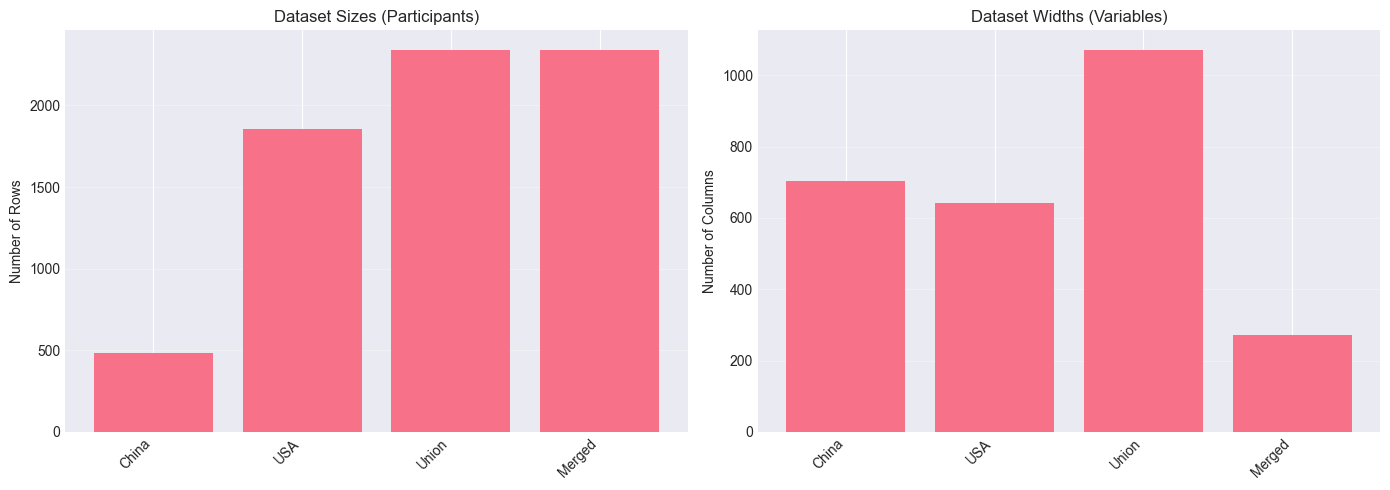

In [346]:
# Visualize dataset sizes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(len(dataset_summary)), dataset_summary["Rows"])
axes[0].set_xticks(range(len(dataset_summary)))
axes[0].set_xticklabels(dataset_summary["Dataset"], rotation=45, ha="right")
axes[0].set_ylabel("Number of Rows")
axes[0].set_title("Dataset Sizes (Participants)")
axes[0].grid(axis="y", alpha=0.3)

axes[1].bar(range(len(dataset_summary)), dataset_summary["Columns"])
axes[1].set_xticks(range(len(dataset_summary)))
axes[1].set_xticklabels(dataset_summary["Dataset"], rotation=45, ha="right")
axes[1].set_ylabel("Number of Columns")
axes[1].set_title("Dataset Widths (Variables)")
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

In [347]:
print("Key observations:")
print(f"Union has maximum columns ({union_with_suffix.shape[1]}) - all variables with suffixes.")
print(f"Merged has {merged.shape[1]} columns - balanced for analysis.")

Key observations:
Union has maximum columns (1072) - all variables with suffixes.
Merged has 273 columns - balanced for analysis.


# 4.0. Data Quality Summary

## 4.1. Data Quality by Country

In [348]:
print("DATA QUALITY SUMMARY BY COUNTRY")

for country in ["China", "USA"]:
    df_country = merged[merged["Country"] == country]
    print(f"{country} (N={len(df_country)})")
    for comp in ["TENS_Life_mean", "ET_mean", "SSRPH_mean", "PHQ5_mean", "GAAIS_mean", "UTAUT_AI_mean"]:
        if comp in df_country.columns:
            n_valid = df_country[comp].notna().sum()
            mean = df_country[comp].mean()
            std = df_country[comp].std()
            print(f"{comp:20} N={n_valid:4}, M={mean:.2f}, SD={std:.2f}")
    print()

DATA QUALITY SUMMARY BY COUNTRY
China (N=485)
TENS_Life_mean       N= 485, M=4.35, SD=0.99
ET_mean              N= 485, M=4.70, SD=0.91
SSRPH_mean           N= 485, M=2.30, SD=0.93
PHQ5_mean            N= 485, M=1.53, SD=0.99
GAAIS_mean           N= 485, M=4.57, SD=0.69
UTAUT_AI_mean        N= 485, M=3.64, SD=0.55

USA (N=1857)
TENS_Life_mean       N=1618, M=4.88, SD=1.00
ET_mean              N=1620, M=4.15, SD=0.80
SSRPH_mean           N=1607, M=0.93, SD=0.76
PHQ5_mean            N=1621, M=1.39, SD=1.05
GAAIS_mean           N=1726, M=4.62, SD=0.82
UTAUT_AI_mean        N=1677, M=5.10, SD=1.38



## 4.2. Reliability Analysis (Cronbach's Alpha)

Compute internal consistency reliability for all scales by country

In [349]:
def cronbach_alpha(df, cols):

    items = df[cols].dropna()
    if len(items) == 0:
        return np.nan
    
    k = items.shape[1]
    if k < 2:
        return np.nan
    
    # Variance of each item
    item_var = items.var(axis=0, ddof=1).sum()
    
    # Variance of total score
    total_var = items.sum(axis=1).var(ddof=1)
    
    if total_var == 0:
        return np.nan
    
    alpha = (k / (k - 1)) * (1 - item_var / total_var)
    return alpha

In [350]:
# Ensure GAAIS_neg_rev exists in both country-level dataframes
for df_ in [cn_coalesced, usa_renamed]:
    if 'GAAIS_neg' in df_.columns:
        df_['GAAIS_neg_rev'] = 8 - df_['GAAIS_neg']

# Define full scale item sets
scale_items_country = {
    "TENS_Life": ['TENS_Life_1r', 'TENS_Life_2r', 'TENS_Life_3r', 'TENS_Life_4r',
                  'TENS_Life_5r', 'TENS_Life_6r', 'TENS_Life_7', 'TENS_Life_8', 'TENS_Life_9'],
    "ET":        [f'ET_{i}' for i in range(1, 16)],
    "SSRPH":     [f'SSRPH_{i}' for i in range(1, 6)],
    "PHQ5":      [f'PHQ5_{i}' for i in range(1, 6)],
    "GAAIS_overall": ['GAAIS_pos', 'GAAIS_neg_rev'],
}

In [351]:
print("CRONBACH'S ALPHA (FULL SCALES) BY COUNTRY")
print("=" * 60)

for country_name, df_country in [("China", cn_coalesced), ("USA", usa_renamed)]:
    print(f"{country_name}:")
    print("-" * 60)
    for scale_name, items in scale_items_country.items():
        available_items = [col for col in items if col in df_country.columns]
        if len(available_items) >= 2:
            alpha = cronbach_alpha(df_country, available_items)
            n_items = len(available_items)
            n_valid = df_country[available_items].dropna().shape[0]
            print(f"{scale_name:15} α = {alpha:.3f}  (k={n_items:2}, n={n_valid:4})")
    print()

CRONBACH'S ALPHA (FULL SCALES) BY COUNTRY
China:
------------------------------------------------------------
TENS_Life       α = 0.823  (k= 9, n= 485)
ET              α = 0.877  (k=15, n= 485)
SSRPH           α = 0.892  (k= 5, n= 485)
PHQ5            α = 0.881  (k= 5, n= 485)
GAAIS_overall   α = 0.059  (k= 2, n= 485)

USA:
------------------------------------------------------------
TENS_Life       α = 0.629  (k= 9, n= 507)
ET              α = 0.781  (k=15, n=1620)
SSRPH           α = 0.859  (k= 5, n=1607)
PHQ5            α = 0.890  (k= 5, n=1621)
GAAIS_overall   α = 0.661  (k= 2, n=1726)



# 5.0. Missing Data & Imputation

## 5.1. Missingness Summary for Key Variables
- Sets up the data quality context for later regression/mediation models.
- Set a foundation for confounders reported before moderation

In [352]:
h_vars = [
    "TENS_Life_mean", "UTAUT_AI_mean", "GAAIS_mean",
    "ET_mean", "PHQ5_mean", "SSRPH_mean", "age",
]

print("Missing data summary before imputation:")
print("-" * 50)
for var in h_vars:
    if var in merged.columns:
        n_missing = merged[var].isna().sum()
        pct_missing = (n_missing / len(merged)) * 100
        print(f"{var:20} {n_missing:4} missing ({pct_missing:5.1f}%)")

complete_before = merged[h_vars].dropna()
print(
    f"\nComplete cases (listwise deletion across h_vars): "
    f"{len(complete_before)} / {len(merged)} ({len(complete_before)/len(merged)*100:.1f}%)"
)

Missing data summary before imputation:
--------------------------------------------------
TENS_Life_mean        239 missing ( 10.2%)
UTAUT_AI_mean         180 missing (  7.7%)
GAAIS_mean            131 missing (  5.6%)
ET_mean               237 missing ( 10.1%)
PHQ5_mean             236 missing ( 10.1%)
SSRPH_mean            250 missing ( 10.7%)
age                   115 missing (  4.9%)

Complete cases (listwise deletion across h_vars): 2085 / 2342 (89.0%)


## 5.2. Missing Design Matrix

- Uses gender and Country as predictors in imputation, which is reasonable and consistent with later moderator/control structure.

In [354]:
impute_vars = h_vars + ["gender", "Country"]
impute_df = merged[impute_vars].copy()

impute_df_encoded = pd.get_dummies(impute_df, columns=["gender", "Country"], drop_first=True)

print(f"Imputation dataset shape: {impute_df_encoded.shape}")
print("Variables:", list(impute_df_encoded.columns))

Imputation dataset shape: (2342, 11)
Variables: ['TENS_Life_mean', 'UTAUT_AI_mean', 'GAAIS_mean', 'ET_mean', 'PHQ5_mean', 'SSRPH_mean', 'age', 'gender_2.0', 'gender_3.0', 'gender_4.0', 'Country_USA']


## 5.3. Iterative Imputation & Storage

### 5.3.1. Iterative Impututation (MICE-Imputation)
- This does not alter original variables; it simply creates parallel *_imputed columns for robustness checks in later hypothesis models.

In [355]:
imputer = IterativeImputer(random_state=42, max_iter=10)
imputed_array = imputer.fit_transform(impute_df_encoded)

merged_imputed = pd.DataFrame(imputed_array, columns=impute_df_encoded.columns, index=merged.index)

for var in h_vars:
    merged[f"{var}_imputed"] = merged_imputed[var]

print("Imputation complete.")
print("Imputed variables created:")
print([f"{v}_imputed" for v in h_vars])

Imputation complete.
Imputed variables created:
['TENS_Life_mean_imputed', 'UTAUT_AI_mean_imputed', 'GAAIS_mean_imputed', 'ET_mean_imputed', 'PHQ5_mean_imputed', 'SSRPH_mean_imputed', 'age_imputed']


### 5.3.2. Compare distributions before and after imputation
- Shows that imputation does not dramatically distort distributions.
- This supports your methodological claim that imputed vs observed distributions are very similar.

In [357]:
print("Comparison of means before/after imputation:")
print("=" * 60)
print(f"{'Variable':20} {'Original':>12} {'Imputed':>12} {'Diff':>10}")
print("-" * 60)

for var in h_vars:
    if var in merged.columns and f"{var}_imputed" in merged.columns:
        orig_mean = merged[var].mean()
        imp_mean = merged[f"{var}_imputed"].mean()
        diff = imp_mean - orig_mean
        print(f"{var:20} {orig_mean:12.3f} {imp_mean:12.3f} {diff:10.3f}")

Comparison of means before/after imputation:
Variable                 Original      Imputed       Diff
------------------------------------------------------------
TENS_Life_mean              4.759        4.775      0.016
UTAUT_AI_mean               4.776        4.797      0.021
GAAIS_mean                  4.611        4.608     -0.003
ET_mean                     4.273        4.253     -0.020
PHQ5_mean                   1.422        1.414     -0.008
SSRPH_mean                  1.246        1.208     -0.038
age                        34.159       34.464      0.306
